In [3]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install scalecast
!pip3 install seaborn
!pip3 install keras
!pip3 install darts
# brew install libomp

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
from darts import TimeSeries
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [2]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y)
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.head()

Time taken to read the data is :  9.149711608886719


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
0,_result,0,2022-02-02 12:41:45.189895+00:00,2024-02-03 00:41:45.189895+00:00,2022-02-02 12:45:00+00:00,energy_production,DE,1136.25,2708.75,1523.50,1010.00,2218.75,21.25,39.00,423.00,1545.75,266.25,927.75,8313.75
1,_result,0,2022-02-02 12:41:45.189895+00:00,2024-02-03 00:41:45.189895+00:00,2022-02-02 13:00:00+00:00,energy_production,DE,1130.75,2768.50,1573.00,1009.25,2093.50,43.75,39.00,423.25,1585.25,269.25,825.75,8097.00
2,_result,0,2022-02-02 12:41:45.189895+00:00,2024-02-03 00:41:45.189895+00:00,2022-02-02 13:15:00+00:00,energy_production,DE,1151.00,2833.75,1598.25,1003.75,1971.75,76.75,39.25,422.50,1620.25,284.25,847.75,7545.25
3,_result,0,2022-02-02 12:41:45.189895+00:00,2024-02-03 00:41:45.189895+00:00,2022-02-02 13:30:00+00:00,energy_production,DE,1152.50,2822.75,1602.75,1006.25,1864.50,179.25,39.25,423.75,1641.50,283.00,875.50,7597.25
4,_result,0,2022-02-02 12:41:45.189895+00:00,2024-02-03 00:41:45.189895+00:00,2022-02-02 13:45:00+00:00,energy_production,DE,1156.50,2881.50,1660.25,1016.75,1701.25,339.00,39.00,425.00,1659.00,284.50,862.00,7462.00


In [3]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

# Sort the DataFrame by index
df = df.sort_index()

df_Wasserkraft = df[["Wasserkraft"]]

print(df_Wasserkraft)
nan_count = df_Wasserkraft.isna().sum()
print("df_Wasserkraft shape is : ", df_Wasserkraft.shape)
print("Number of NaN values in 'Wasserkraft' column:", nan_count)
df_Wasserkraft = df_Wasserkraft.ffill() # forward filling missing values
print("df_Wasserkraft_cleaned shape is : ", df_Wasserkraft.shape)

                           Wasserkraft
_time                                 
2022-02-02 12:45:00+00:00       266.25
2022-02-02 13:00:00+00:00       269.25
2022-02-02 13:15:00+00:00       284.25
2022-02-02 13:30:00+00:00       283.00
2022-02-02 13:45:00+00:00       284.50
...                                ...
2024-02-02 22:45:00+00:00          NaN
2024-02-02 23:00:00+00:00          NaN
2024-02-02 23:15:00+00:00          NaN
2024-02-02 23:30:00+00:00          NaN
2024-02-02 23:45:00+00:00          NaN

[70093 rows x 1 columns]
df_Wasserkraft shape is :  (70093, 1)
Number of NaN values in 'Wasserkraft' column: Wasserkraft    363
dtype: int64
df_Wasserkraft_cleaned shape is :  (70093, 1)


In [4]:
df_Wasserkraft.head()

,Wasserkraft
_time,
2022-02-02 12:45:00+00:00,266.25
2022-02-02 13:00:00+00:00,269.25
2022-02-02 13:15:00+00:00,284.25
2022-02-02 13:30:00+00:00,283.00
2022-02-02 13:45:00+00:00,284.50


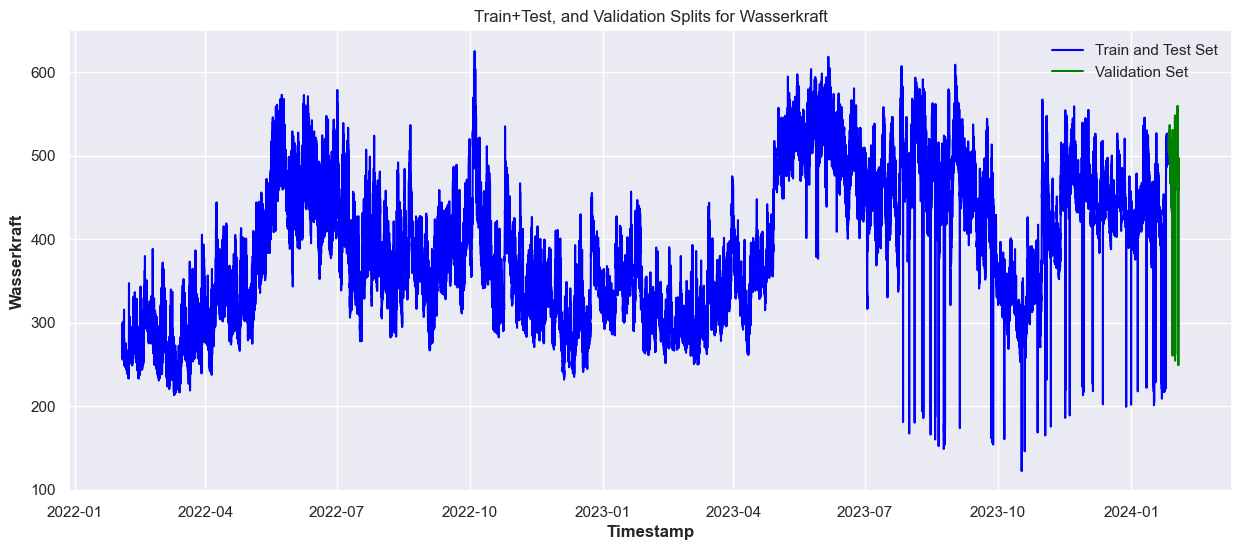

In [5]:
# Train, Test and Validation Splits
train_test_data = df_Wasserkraft[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Wasserkraft[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Wasserkraft'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Wasserkraft'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Wasserkraft')
plt.xlabel('Timestamp')
plt.ylabel('Wasserkraft')
plt.legend()
plt.show()

In [6]:
f = Forecaster(y=train_test_data.Wasserkraft,current_dates=train_test_data.index, freq='15T')

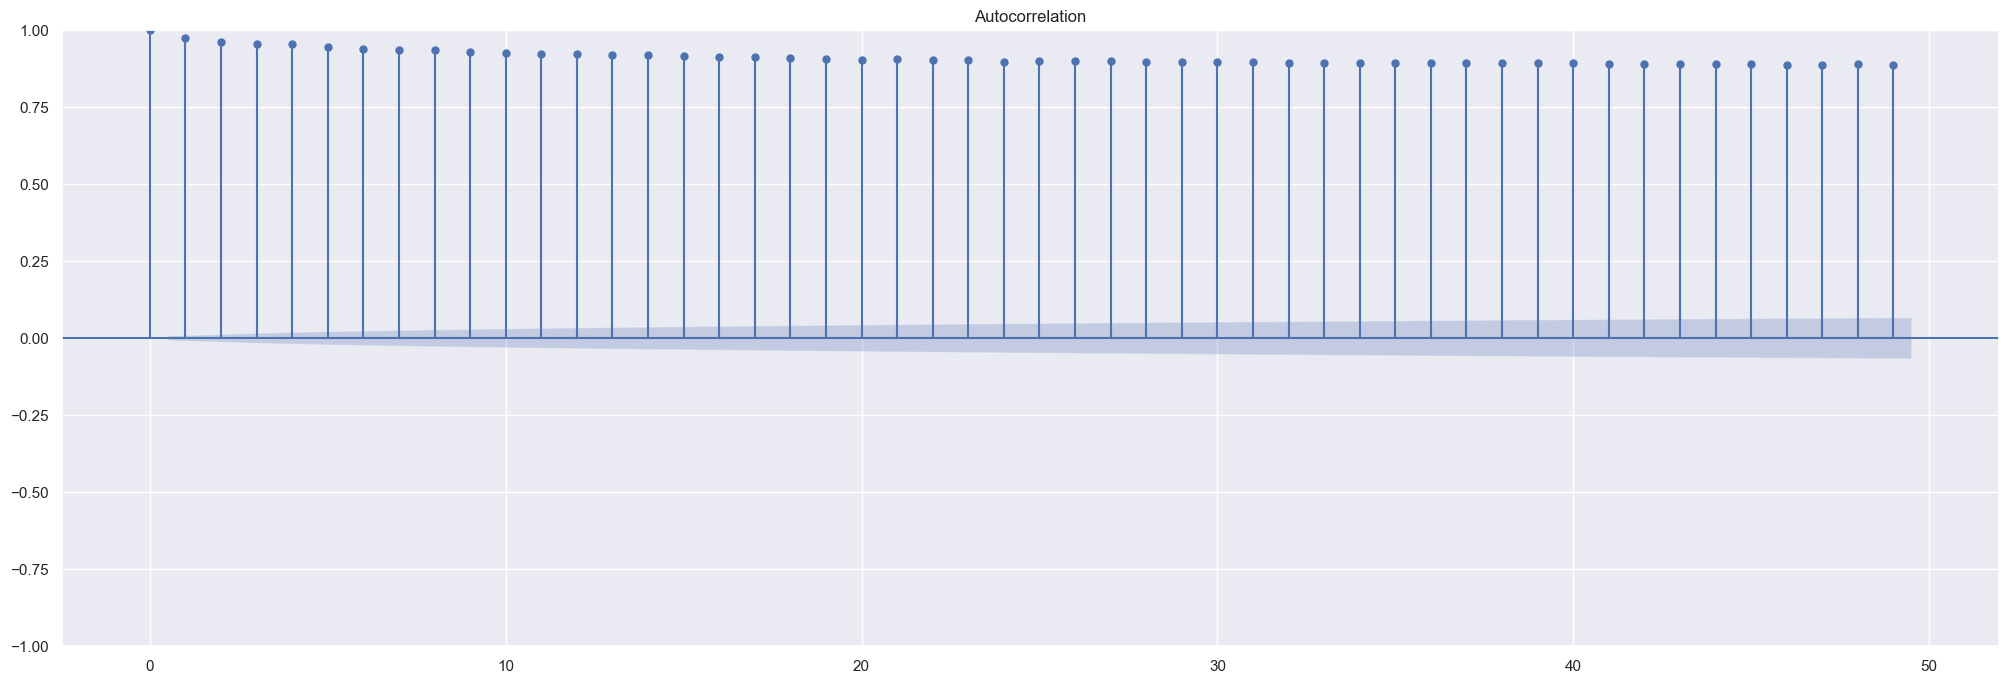

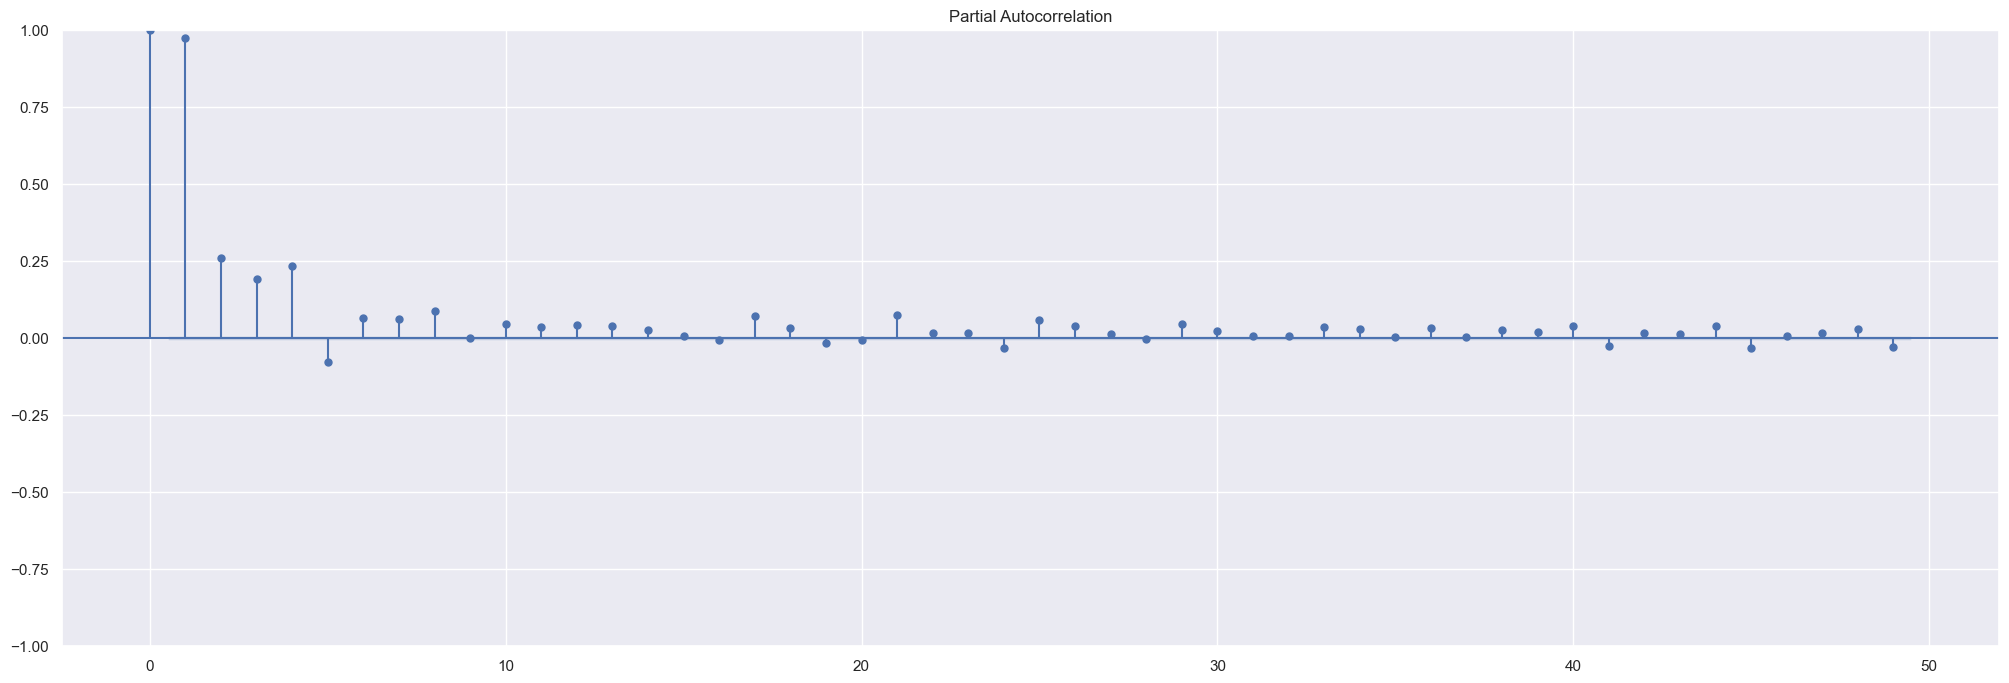

In [7]:
f.plot_acf()
f.plot_pacf()
plt.show()

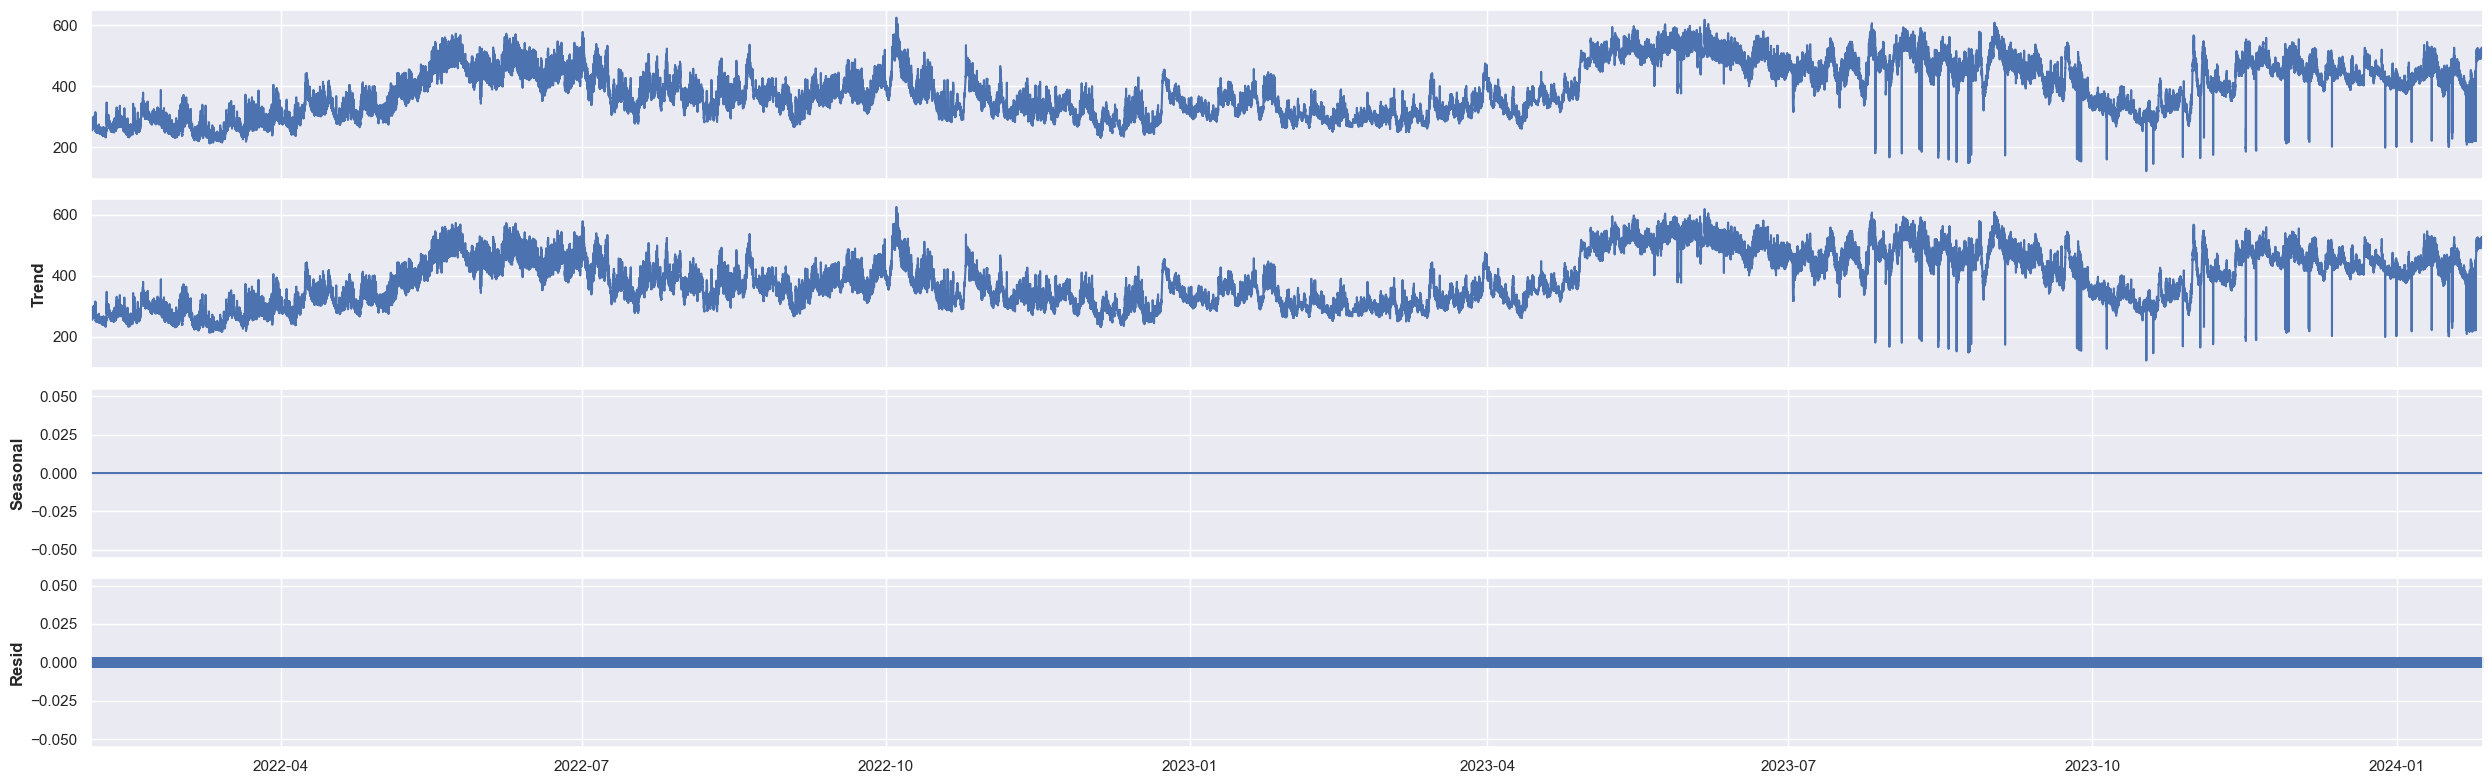

In [8]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [9]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

True


In [10]:
f.set_test_length(0.10)

In [11]:
f.eval_cis()

In [12]:
f.add_time_trend()

In [13]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [14]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

Epoch 1/25
1561/1561 [==============================] - 316s 184ms/step - loss: 0.1231 - val_loss: 0.1284
Epoch 2/25
1561/1561 [==============================] - 253s 162ms/step - loss: 0.1091 - val_loss: 0.1378
Epoch 3/25
1561/1561 [==============================] - 261s 167ms/step - loss: 0.1089 - val_loss: 0.1330
Epoch 4/25
1561/1561 [==============================] - 263s 168ms/step - loss: 0.1085 - val_loss: 0.1331
Epoch 5/25
1561/1561 [==============================] - 265s 170ms/step - loss: 0.1083 - val_loss: 0.1334
Epoch 6/25
1561/1561 [==============================] - 282s 181ms/step - loss: 0.1082 - val_loss: 0.1334
Epoch 7/25
1561/1561 [==============================] - 265s 170ms/step - loss: 0.1079 - val_loss: 0.1314
Epoch 8/25
1561/1561 [==============================] - 279s 179ms/step - loss: 0.1078 - val_loss: 0.1315
Epoch 9/25
1/1 [==============================] - 5s 5s/step


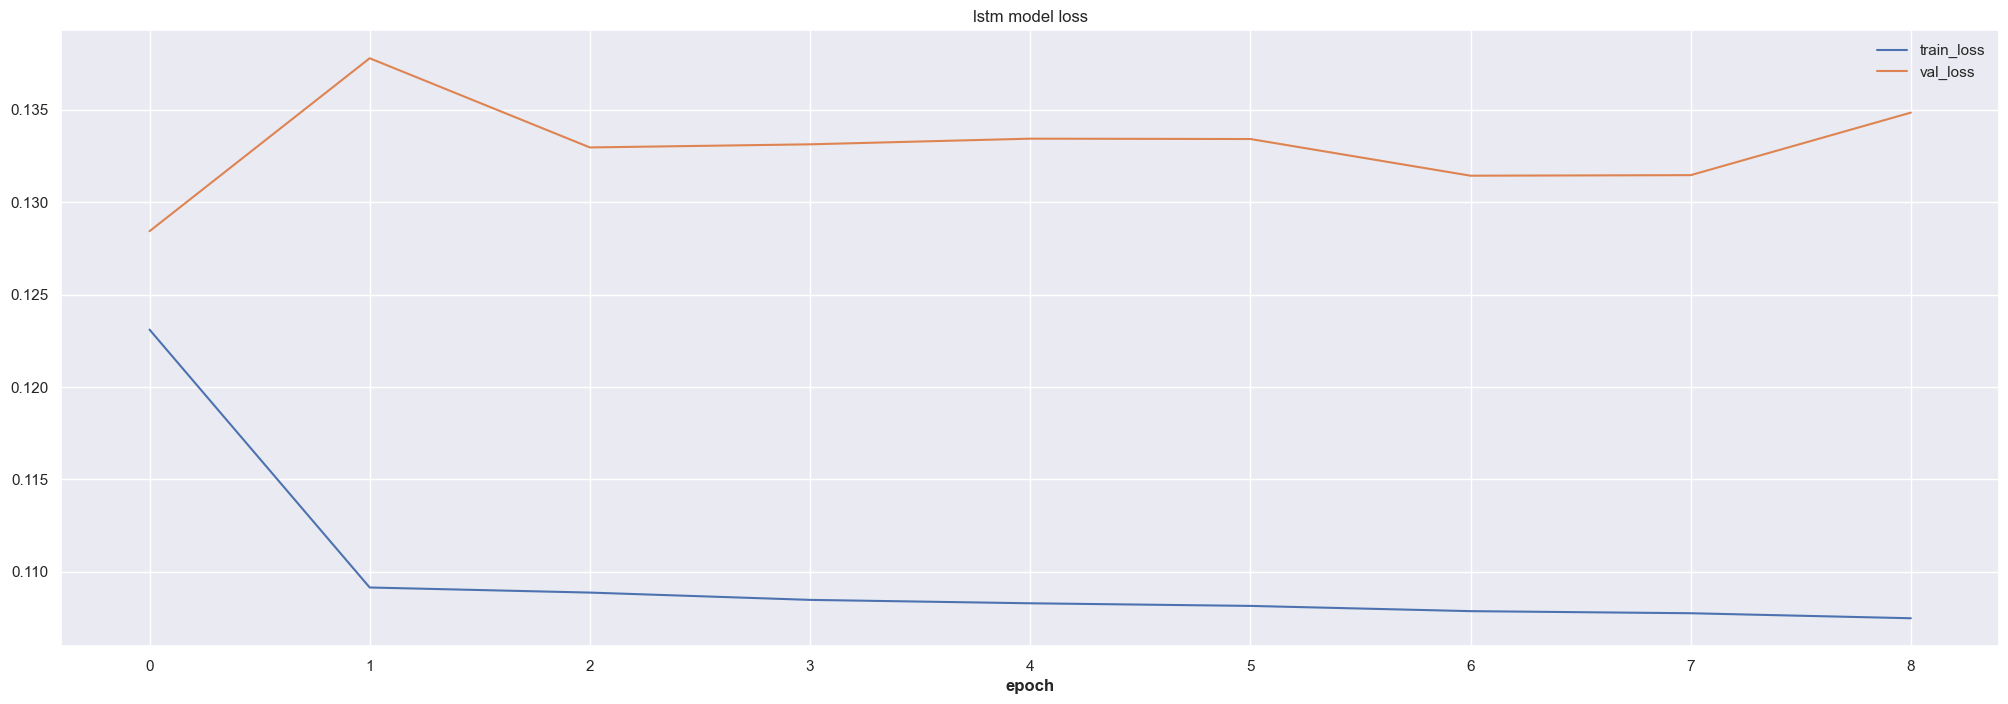

Epoch 1/25
1914/1914 [==============================] - 414s 194ms/step - loss: 0.0899 - val_loss: 0.0747
Epoch 2/25
1914/1914 [==============================] - 391s 204ms/step - loss: 0.0828 - val_loss: 0.0774
Epoch 3/25
1914/1914 [==============================] - 356s 186ms/step - loss: 0.0826 - val_loss: 0.0752
Epoch 4/25
1914/1914 [==============================] - 349s 182ms/step - loss: 0.0821 - val_loss: 0.0756
Epoch 5/25
1914/1914 [==============================] - 358s 187ms/step - loss: 0.0818 - val_loss: 0.0732
Epoch 6/25
1914/1914 [==============================] - 357s 186ms/step - loss: 0.0816 - val_loss: 0.0805
Epoch 7/25
1914/1914 [==============================] - 382s 200ms/step - loss: 0.0815 - val_loss: 0.0750
Epoch 8/25
1914/1914 [==============================] - 386s 202ms/step - loss: 0.0834 - val_loss: 0.0756
Epoch 9/25
1914/1914 [==============================] - 401s 210ms/step - loss: 0.0819 - val_loss: 0.0742
Epoch 10/25
1914/1914 [=======================

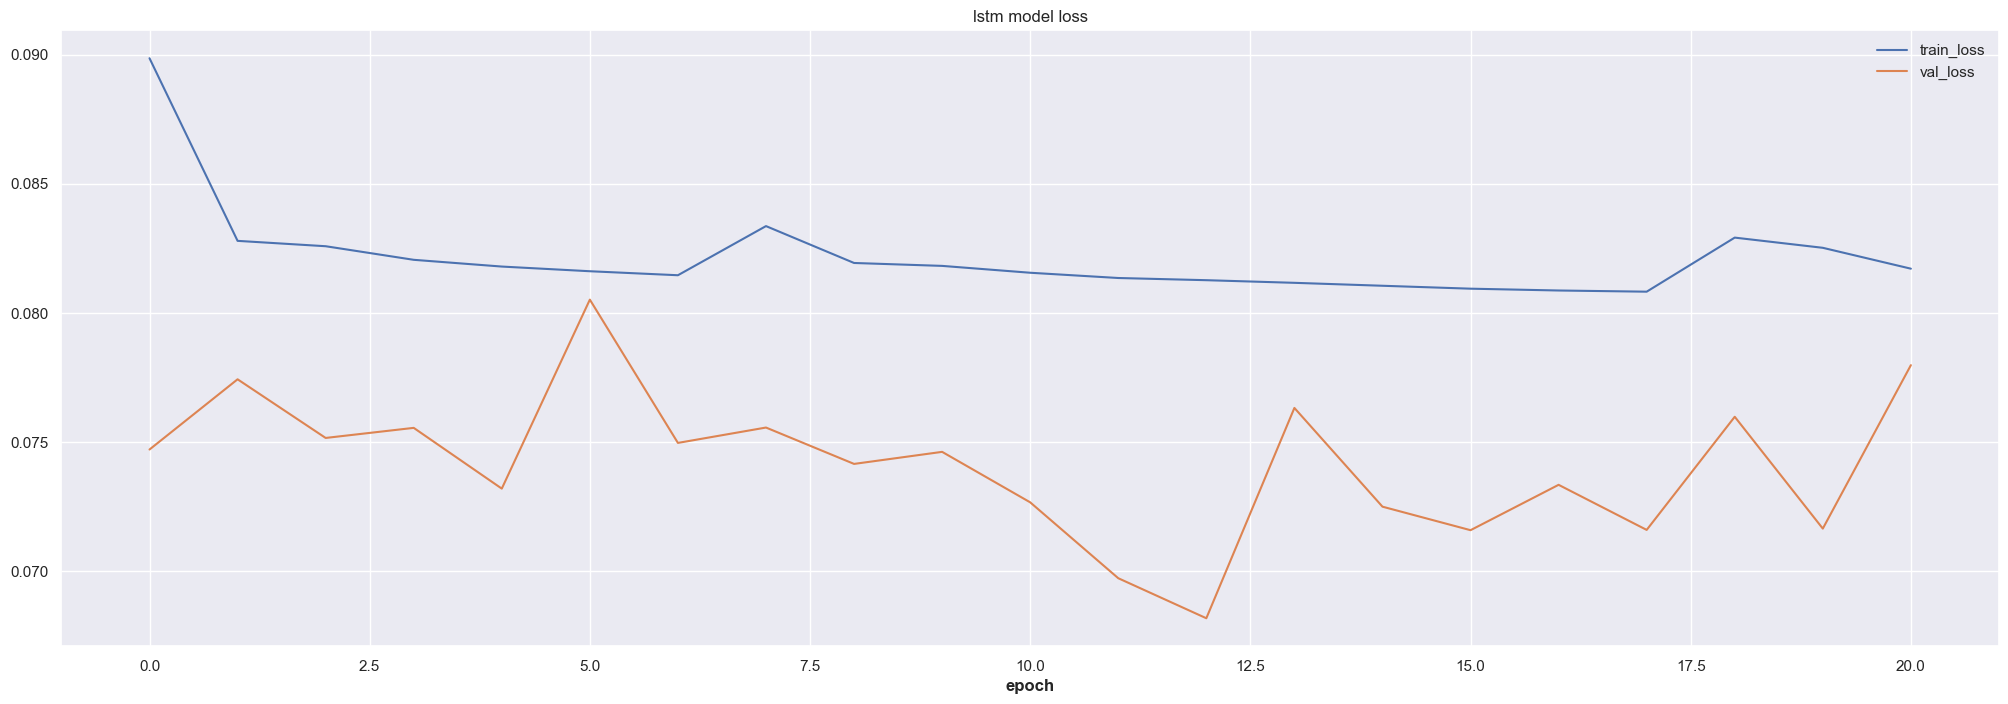

In [15]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

Mean Absolute Error (MAE) prediction vs validation set : 23.903390503577178


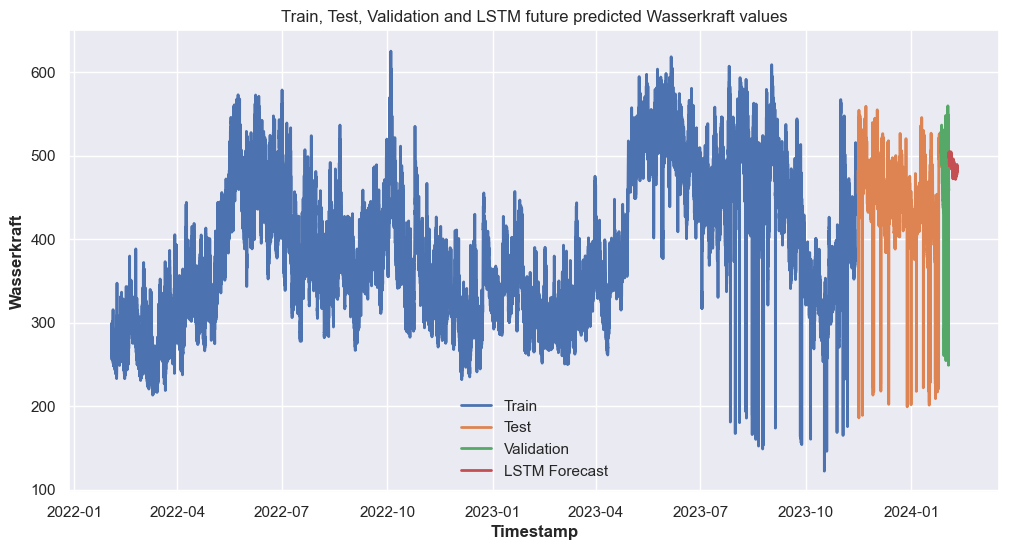

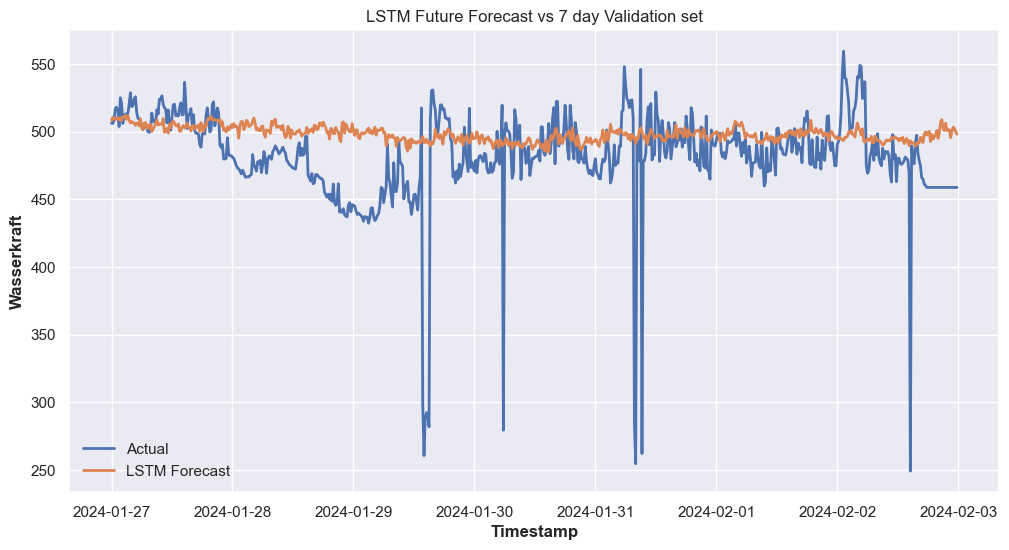

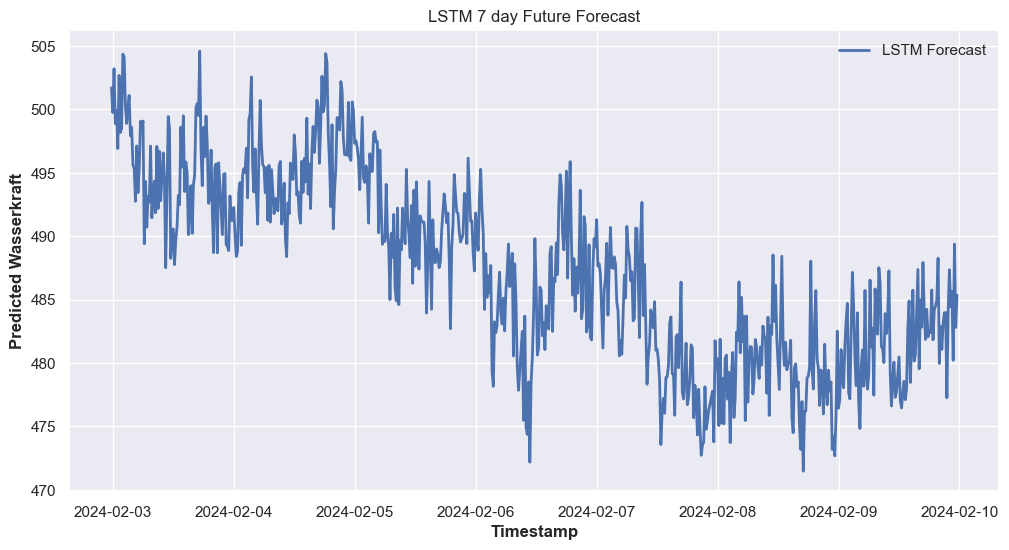

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Get future forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series

# Calculate MAE
mae = mean_absolute_error(validation_data["Wasserkraft"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Wasserkraft"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = root_mean_squared_error(validation_data["Wasserkraft"].values, lstm_default_forecasted_df["lstm_best"].values[:672])

# Add more metrics here
print(f'Mean Absolute Error (MAE) prediction vs validation set : {mae}')
print(f'Mean Absolute Percentage Error (MAPE) prediction vs validation set : {mape*100:.2f}%')
print(f'Root Mean Squared Error (RMSE) prediction vs validation set : {rmse}')


# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Wasserkraft"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Wasserkraft"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Wasserkraft')
plt.title('Train, Test, Validation and LSTM future predicted Wasserkraft values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Wasserkraft"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Wasserkraft')
plt.title('LSTM Future Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Wasserkraft')
plt.title('LSTM 7 day Future Forecast')
plt.legend()
plt.show()


In [65]:
forecasted_values = lstm_default_forecasted_df["lstm_best"][672:]
forecasted_values
forecasted_values.to_csv('Wasserkraft_Future_7_days.csv', index_label='Timestamp', encoding='utf-8')

In [61]:
forecasted_values_corrected = lstm_default_forecasted_df["lstm_best"][:672].values

combined_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual Wasserkraft': validation_data['Wasserkraft'].values,
    'Forecasted Wasserkraft': forecasted_values_corrected
})

# Export to CSV
combined_df.to_csv('Wasserkraft_Actual_vs_Forecasted.csv', index=False, encoding='utf-8')